# Notes 2 - Predictors of recorded DS live births

Next:

- Review data to see if we can go back further - check race
- Hyperparameter tuning
- Consider bagging vs GOSS


## Preparation


In [1]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = repl_utils.RANDOM_SEED
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0002-predictors/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


-------------------- Environment Information --------------------
date: 2025-12-22T11:24:36.287048
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
cores: 32
physical_cores: 24
ram: 127 GB
ram_available: 95 GB
cuda: True
cuda_device_count: 1
cuda_device_0: NVIDIA GeForce RTX 4070 Ti SUPER
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0002-predictors/20251222-112436
--------------------



### Options


In [ ]:
START_YEAR = 2005
# LightGBM threads
NUM_THREADS = N_CORES
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.5
VALIDATION_SPLIT = 0.25
CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 5000 # 10000
EARLY_STOPPING_ROUNDS = 10
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = False
#
OPTIMIZE_TRIALS = 40

SAVE_PLOTS = True

### Load data


In [3]:
df = data_utils.load_predictors_data(from_year=START_YEAR)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [4]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    vars.DOB_MM,
    vars.DOB_WK,
    "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"]

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data


In [5]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TRAINING_SPLIT, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp,
    y_tmp,
    test_size=(VALIDATION_SPLIT / TRAINING_SPLIT),
    stratify=y_tmp,
    random_state=RANDOM_SEED,
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [6]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

neg_count_cal = y_cal[y_cal == 0].count()
pos_count_cal = y_cal[y_cal == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)
print(
    f"Calibration set: {neg_count_cal} negatives, {pos_count_cal} positives, probability positive {pos_count_cal / neg_count_cal:.8f}"
)

Training set: 39061040 negatives, 19869 positives, probability positive 0.00050867
Validation set: 19530520 negatives, 9934 positives, probability positive 0.00050864
Calibration set: 19530521 negatives, 9934 positives, probability positive 0.00050864


In [ ]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {
    "learning_rate": 0.014891637649695044,
    "num_leaves": 81,
    "min_data_in_leaf": 864,
    "min_gain_to_split": 0.3567776136266129,
    "feature_fraction": 0.610222833973872,
    "bagging_fraction": 0.9226890884051586,
    "bagging_freq": 6,
    "lambda_l1": 0.00021596947276958148,
    "lambda_l2": 8.98208844422193,
}

## Hyperparameter tuning


In [8]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

[I 2025-12-22 11:27:03,669] A new study created in memory with name: no-name-b03465bf-9922-4c55-ab1f-e2a745208d60


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.138634	valid_0's binary_logloss: 0.0101805


[I 2025-12-22 11:27:57,808] Trial 0 finished with value: 0.5141513215747883 and parameters: {'learning_rate': 0.13737057476742426, 'num_leaves': 137, 'min_data_in_leaf': 1528, 'min_gain_to_split': 0.728392129665594, 'feature_fraction': 0.7036488543794517, 'bagging_fraction': 0.7631910392589718, 'bagging_freq': 9, 'lambda_l1': 5.622968695007702e-06, 'lambda_l2': 1.9830313678733256}. Best is trial 0 with value: 0.5141513215747883.


Early stopping, best iteration is:
[4]	valid_0's average_precision: 0.514151	valid_0's binary_logloss: 0.0119307
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.145295	valid_0's binary_logloss: 0.0193314


[I 2025-12-22 11:28:16,363] Trial 1 finished with value: 0.25176983209575815 and parameters: {'learning_rate': 0.16188499445530202, 'num_leaves': 106, 'min_data_in_leaf': 3814, 'min_gain_to_split': 0.3090637933448034, 'feature_fraction': 0.925385904263971, 'bagging_fraction': 0.7758602376351182, 'bagging_freq': 4, 'lambda_l1': 0.0021646008109838903, 'lambda_l2': 0.03428578854704987}. Best is trial 0 with value: 0.5141513215747883.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.25177	valid_0's binary_logloss: 0.0256524
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.537999	valid_0's binary_logloss: 0.00227918
[20]	valid_0's average_precision: 0.538265	valid_0's binary_logloss: 0.00208127
[30]	valid_0's average_precision: 0.538765	valid_0's binary_logloss: 0.00198592
[40]	valid_0's average_precision: 0.539525	valid_0's binary_logloss: 0.00193693
[50]	valid_0's average_precision: 0.540073	valid_0's binary_logloss: 0.00191078
[60]	valid_0's average_precision: 0.540777	valid_0's binary_logloss: 0.00189524
[70]	vali

[I 2025-12-22 11:32:25,975] Trial 2 finished with value: 0.5427452628712004 and parameters: {'learning_rate': 0.05150690580427416, 'num_leaves': 49, 'min_data_in_leaf': 1176, 'min_gain_to_split': 0.9222758108354657, 'feature_fraction': 0.9402484354132102, 'bagging_fraction': 0.8432957394871852, 'bagging_freq': 10, 'lambda_l1': 0.004023791011146146, 'lambda_l2': 0.005264067328349962}. Best is trial 2 with value: 0.5427452628712004.


Early stopping, best iteration is:
[151]	valid_0's average_precision: 0.542745	valid_0's binary_logloss: 0.00186945
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 11:32:31,070] Trial 3 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.303453	valid_0's binary_logloss: 0.00375411
[20]	valid_0's average_precision: 0.317529	valid_0's binary_logloss: 0.0030812
[30]	valid_0's average_precision: 0.353674	valid_0's binary_logloss: 0.00273018
[40]	valid_0's average_precision: 0.3963	valid_0's binary_logloss: 0.00251604
[50]	valid_0's average_precision: 0.432275	valid_0's binary_logloss: 0.0023702
[60]	valid_0's average_precision: 0.451869	valid_0's binary_logloss: 0.00227777
[70]	valid_0's average_precision: 0.468157	valid_0's binary_logloss: 0.00220634
[80]	valid_0's average_precision: 0.483412	va

[I 2025-12-22 11:45:08,279] Trial 4 finished with value: 0.5429527790982107 and parameters: {'learning_rate': 0.026459412363768624, 'num_leaves': 45, 'min_data_in_leaf': 4091, 'min_gain_to_split': 0.10392271399632647, 'feature_fraction': 0.7238038095066436, 'bagging_fraction': 0.8109724948112838, 'bagging_freq': 10, 'lambda_l1': 1.7534444412644385e-05, 'lambda_l2': 4.149826346538422e-08}. Best is trial 4 with value: 0.5429527790982107.


[400]	valid_0's average_precision: 0.542979	valid_0's binary_logloss: 0.00189228
Early stopping, best iteration is:
[390]	valid_0's average_precision: 0.542953	valid_0's binary_logloss: 0.00189222
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 11:45:13,227] Trial 5 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 11:45:17,120] Trial 6 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.53903	valid_0's binary_logloss: 0.00221685
[20]	valid_0's average_precision: 0.541038	valid_0's binary_logloss: 0.00202187
[30]	valid_0's average_precision: 0.544105	valid_0's binary_logloss: 0.00193624
[40]	valid_0's average_precision: 0.546159	valid_0's binary_logloss: 0.00189387
[50]	valid_0's average_precision: 0.546937	valid_0's binary_logloss: 0.00187468
[60]	valid_0's average_precision: 0.547568	valid_0's binary_logloss: 0.00186441
[70]	valid_0's average_precision: 0.547849	valid_0's binary_logloss: 0.00185931
[80]	valid_0's average_precision: 0.548109

[I 2025-12-22 11:48:13,904] Trial 7 finished with value: 0.5483647225217977 and parameters: {'learning_rate': 0.06286127520743323, 'num_leaves': 54, 'min_data_in_leaf': 765, 'min_gain_to_split': 0.41270652488882864, 'feature_fraction': 0.9289883414688569, 'bagging_fraction': 0.8517172239483219, 'bagging_freq': 4, 'lambda_l1': 2.203534439617733e-08, 'lambda_l2': 0.2630608316797082}. Best is trial 7 with value: 0.5483647225217977.


Early stopping, best iteration is:
[97]	valid_0's average_precision: 0.548365	valid_0's binary_logloss: 0.00185272
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.546001	valid_0's binary_logloss: 0.00217149
[20]	valid_0's average_precision: 0.548026	valid_0's binary_logloss: 0.00204937
[30]	valid_0's average_precision: 0.548934	valid_0's binary_logloss: 0.00198047
[40]	valid_0's average_precision: 0.549676	valid_0's binary_logloss: 0.00193581
[50]	valid_0's average_precision: 0.550284	valid_0's binary_logloss: 0.00190648
[60]	valid_0's average_precision: 0.550546	valid_0's binary_logloss: 0.00188695
[70]	v

[I 2025-12-22 11:50:35,146] Trial 8 finished with value: 0.5509971013049775 and parameters: {'learning_rate': 0.034944680948487766, 'num_leaves': 195, 'min_data_in_leaf': 525, 'min_gain_to_split': 0.37983479760655925, 'feature_fraction': 0.8489003248071448, 'bagging_fraction': 0.6032200980144449, 'bagging_freq': 6, 'lambda_l1': 0.0012895278147347358, 'lambda_l2': 3.4844048199341624}. Best is trial 8 with value: 0.5509971013049775.


[90]	valid_0's average_precision: 0.550977	valid_0's binary_logloss: 0.00185713
Early stopping, best iteration is:
[80]	valid_0's average_precision: 0.550997	valid_0's binary_logloss: 0.00186379
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 11:50:43,075] Trial 9 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 11:50:48,269] Trial 10 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 11:50:52,838] Trial 11 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.511155	valid_0's binary_logloss: 0.00268332
[20]	valid_0's average_precision: 0.528571	valid_0's binary_logloss: 0.00254988
[30]	valid_0's average_precision: 0.53109	valid_0's binary_logloss: 0.00243825
[40]	valid_0's average_precision: 0.532188	valid_0's binary_logloss: 0.002372
[50]	valid_0's average_precision: 0.532756	valid_0's binary_logloss: 0.00231198
[60]	valid_0's average_precision: 0.533379	valid_0's binary_logloss: 0.00226665
[70]	valid_0's average_precision: 0.533929	valid_0's binary_logloss: 0.00222218
[80]	valid_0's average_precision: 0.534385	v

[I 2025-12-22 12:16:45,417] Trial 12 finished with value: 0.5518920780342546 and parameters: {'learning_rate': 0.014891637649695044, 'num_leaves': 81, 'min_data_in_leaf': 864, 'min_gain_to_split': 0.3567776136266129, 'feature_fraction': 0.610222833973872, 'bagging_fraction': 0.9226890884051586, 'bagging_freq': 6, 'lambda_l1': 0.00021596947276958148, 'lambda_l2': 8.98208844422193}. Best is trial 12 with value: 0.5518920780342546.


Early stopping, best iteration is:
[703]	valid_0's average_precision: 0.551892	valid_0's binary_logloss: 0.0018519
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:17:02,367] Trial 13 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:17:10,408] Trial 14 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:17:14,949] Trial 15 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:17:22,133] Trial 16 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:17:29,763] Trial 17 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:17:37,362] Trial 18 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:17:42,171] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:17:49,956] Trial 20 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.537877	valid_0's binary_logloss: 0.00219741
[20]	valid_0's average_precision: 0.540771	valid_0's binary_logloss: 0.00200191
[30]	valid_0's average_precision: 0.544404	valid_0's binary_logloss: 0.00191994
[40]	valid_0's average_precision: 0.546946	valid_0's binary_logloss: 0.00188501
[50]	valid_0's average_precision: 0.548245	valid_0's binary_logloss: 0.00186757
[60]	valid_0's average_precision: 0.548892	valid_0's binary_logloss: 0.00185842
[70]	valid_0's average_precision: 0.549255	valid_0's binary_logloss: 0.00185434
[80]	valid_0's average_precision: 0.54925

[I 2025-12-22 12:20:34,967] Trial 21 finished with value: 0.5493578231110093 and parameters: {'learning_rate': 0.06668775797654576, 'num_leaves': 65, 'min_data_in_leaf': 809, 'min_gain_to_split': 0.4584071446867727, 'feature_fraction': 0.8906351474522534, 'bagging_fraction': 0.8948896044450655, 'bagging_freq': 4, 'lambda_l1': 1.0216016560177865e-07, 'lambda_l2': 0.5700616716687271}. Best is trial 12 with value: 0.5518920780342546.


Early stopping, best iteration is:
[86]	valid_0's average_precision: 0.549358	valid_0's binary_logloss: 0.0018513
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:20:43,049] Trial 22 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:20:48,321] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:21:05,079] Trial 24 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:21:09,349] Trial 25 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:21:23,198] Trial 26 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:21:31,437] Trial 27 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:21:36,195] Trial 28 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:21:41,044] Trial 29 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:21:49,240] Trial 30 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:21:56,278] Trial 31 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.54137	valid_0's binary_logloss: 0.00207122
[20]	valid_0's average_precision: 0.545307	valid_0's binary_logloss: 0.00195993
[30]	valid_0's average_precision: 0.546902	valid_0's binary_logloss: 0.00190801
[40]	valid_0's average_precision: 0.547787	valid_0's binary_logloss: 0.00188113
[50]	valid_0's average_precision: 0.548555	valid_0's binary_logloss: 0.00186695
[60]	valid_0's average_precision: 0.548871	valid_0's binary_logloss: 0.00185949
[70]	valid_0's average_precision: 0.549187	valid_0's binary_logloss: 0.00185472
[80]	valid_0's average_precision: 0.549305

[I 2025-12-22 12:25:00,003] Trial 32 finished with value: 0.5496192273031599 and parameters: {'learning_rate': 0.06427062114349341, 'num_leaves': 57, 'min_data_in_leaf': 706, 'min_gain_to_split': 0.36772314615831636, 'feature_fraction': 0.9442358811325218, 'bagging_fraction': 0.7836228723917559, 'bagging_freq': 4, 'lambda_l1': 8.263600198413152e-08, 'lambda_l2': 1.9479062477805913}. Best is trial 12 with value: 0.5518920780342546.


Early stopping, best iteration is:
[106]	valid_0's average_precision: 0.549619	valid_0's binary_logloss: 0.00184863
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:25:15,661] Trial 33 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.545639	valid_0's binary_logloss: 0.00219429
[20]	valid_0's average_precision: 0.547187	valid_0's binary_logloss: 0.00208477
[30]	valid_0's average_precision: 0.547984	valid_0's binary_logloss: 0.00201597
[40]	valid_0's average_precision: 0.548716	valid_0's binary_logloss: 0.00196952
[50]	valid_0's average_precision: 0.549225	valid_0's binary_logloss: 0.00193641
[60]	valid_0's average_precision: 0.549534	valid_0's binary_logloss: 0.00191233
[70]	valid_0's average_precision: 0.549826	valid_0's binary_logloss: 0.00189513
[80]	valid_0's average_precision: 0.55009

[I 2025-12-22 12:30:48,931] Trial 34 finished with value: 0.5514184736872177 and parameters: {'learning_rate': 0.02776280852992184, 'num_leaves': 67, 'min_data_in_leaf': 945, 'min_gain_to_split': 0.5423366199803541, 'feature_fraction': 0.9437269024835359, 'bagging_fraction': 0.7906121963194315, 'bagging_freq': 5, 'lambda_l1': 3.7071575131602847e-06, 'lambda_l2': 1.109300211227928}. Best is trial 12 with value: 0.5518920780342546.


Early stopping, best iteration is:
[197]	valid_0's average_precision: 0.551418	valid_0's binary_logloss: 0.00184117
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:30:53,201] Trial 35 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	valid_0's average_precision: 0.545493	valid_0's binary_logloss: 0.00216626
[20]	valid_0's average_precision: 0.547389	valid_0's binary_logloss: 0.00205276
[30]	valid_0's average_precision: 0.548215	valid_0's binary_logloss: 0.00198473
[40]	valid_0's average_precision: 0.548862	valid_0's binary_logloss: 0.001941
[50]	valid_0's average_precision: 0.549366	valid_0's binary_logloss: 0.00191163
[60]	valid_0's average_precision: 0.549708	valid_0's binary_logloss: 0.00189115
[70]	valid_0's average_precision: 0.550015	valid_0's binary_logloss: 0.00187721
[80]	valid_0's average_precision: 0.55012	v

[I 2025-12-22 12:34:46,903] Trial 36 finished with value: 0.5507740371491404 and parameters: {'learning_rate': 0.03314659814085767, 'num_leaves': 117, 'min_data_in_leaf': 968, 'min_gain_to_split': 0.9782685212154645, 'feature_fraction': 0.9679634073495678, 'bagging_fraction': 0.8189095558412042, 'bagging_freq': 5, 'lambda_l1': 1.8324412078987603e-06, 'lambda_l2': 1.7406435364201482}. Best is trial 12 with value: 0.5518920780342546.


Early stopping, best iteration is:
[126]	valid_0's average_precision: 0.550774	valid_0's binary_logloss: 0.00184646
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:35:04,302] Trial 37 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:35:11,525] Trial 38 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds


[I 2025-12-22 12:35:15,904] Trial 39 pruned. Trial was pruned at iteration 1.


{'learning_rate': 0.014891637649695044, 'num_leaves': 81, 'min_data_in_leaf': 864, 'min_gain_to_split': 0.3567776136266129, 'feature_fraction': 0.610222833973872, 'bagging_fraction': 0.9226890884051586, 'bagging_freq': 6, 'lambda_l1': 0.00021596947276958148, 'lambda_l2': 8.98208844422193} 0.5518920780342546
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 202512
  "num_threads": 24
  "verbosity": 1
  "learning_rate": 0.014891637649695044
  "num_leaves": 81
  "min_data_in_leaf": 864
  "min_gain_to_split": 0.3567776136266129
  "feature_fraction": 0.610222833973872
  "bagging_fraction": 0.9226890884051586
  "bagging_freq": 6
  "lambda_l1": 0.00021596947276958148
  "lambda_l2": 8.98208844422193
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [9]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	train's average_precision: 0.520851	train's binary_logloss: 0.00266103	valid's average_precision: 0.511155	valid's binary_logloss: 0.00268332
[20]	train's average_precision: 0.536801	train's binary_logloss: 0.00252251	valid's average_precision: 0.528571	valid's binary_logloss: 0.00254988
[30]	train's average_precision: 0.539296	train's binary_logloss: 0.00240661	valid's average_precision: 0.53109	valid's binary_logloss: 0.00243825
[40]	train's average_precision: 0.540463	train's binary_logloss: 0.00233772	valid's average_precision: 0.532188	valid's binary_logloss: 0.002372
[50]	train's ave

In [10]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [11]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.965916
1,Validation AP,0.551892
2,Validation log loss,0.001852
3,Precision at 10000,0.529700
4,Recall at 10000,0.533219
5,Precision (threshold=0.01),0.120366
6,Recall (threshold=0.01),0.619388


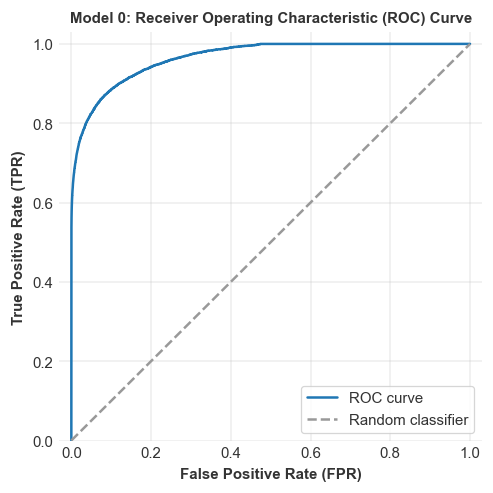

In [12]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

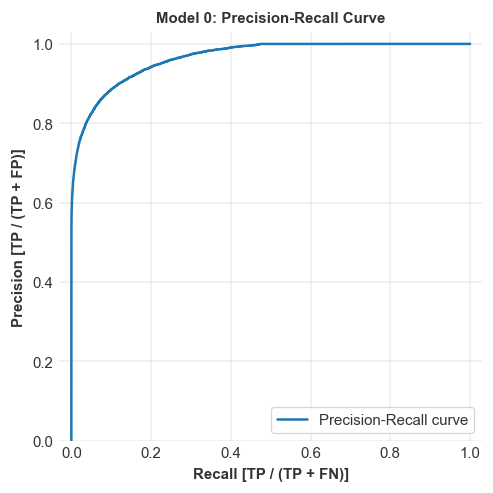

In [13]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

#### Feature importance


In [14]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
41,no_congen,2.985148e+06
32,ca_cchd,5.109397e+05
37,ca_cleft,3.945205e+05
39,ca_hypo,3.409371e+05
53,mage_c,2.902401e+05
35,ca_gast,2.878269e+05
40,ca_disor,2.799636e+05
31,ca_mnsb,2.041245e+05
25,ab_nicu,1.884228e+05
30,ca_anen,1.584204e+05


### Evaluation subset for permutation importances and SHAP analysis


In [15]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [16]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [17]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=5,
    n_jobs=NUM_THREADS,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
41,no_congen,0.493341,0.001917
32,ca_cchd,0.214741,0.002156
40,ca_disor,0.171309,0.001534
37,ca_cleft,0.170567,0.002610
39,ca_hypo,0.140534,0.001780
31,ca_mnsb,0.109563,0.001430
34,ca_omph,0.093121,0.002027
30,ca_anen,0.085892,0.002055
38,ca_clpal,0.080450,0.000983
35,ca_gast,0.074717,0.002123


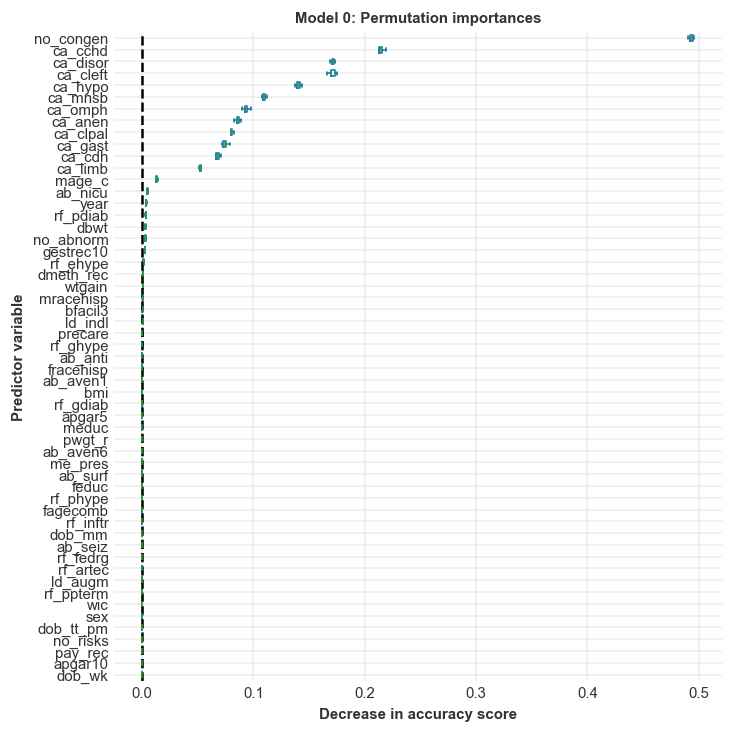

In [18]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

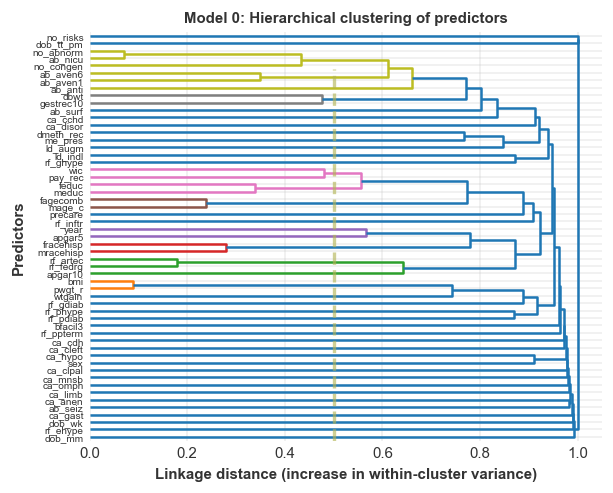

In [19]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

In [ ]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
)

In [20]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
41,no_congen,3.753139
53,mage_c,0.599217
25,ab_nicu,0.457372
49,dbwt,0.280975
6,gestrec10,0.194392
40,ca_disor,0.170648
7,rf_pdiab,0.169607
32,ca_cchd,0.155425
37,ca_cleft,0.085390
43,mracehisp,0.077237


In [21]:
shap_importance["feature"].tolist()

['no_congen',
 'mage_c',
 'ab_nicu',
 'dbwt',
 'gestrec10',
 'ca_disor',
 'rf_pdiab',
 'ca_cchd',
 'ca_cleft',
 'mracehisp',
 'ab_aven1',
 'ca_hypo',
 'year',
 'wtgain',
 'ca_clpal',
 'no_abnorm',
 'ab_anti',
 'fracehisp',
 'rf_ehype',
 'ca_limb',
 'rf_ghype',
 'ca_cdh',
 'precare',
 'fagecomb',
 'ca_gast',
 'rf_gdiab',
 'ca_omph',
 'ca_mnsb',
 'rf_phype',
 'dmeth_rec',
 'ab_aven6',
 'meduc',
 'ca_anen',
 'pwgt_r',
 'dob_mm',
 'bfacil3',
 'apgar5',
 'bmi',
 'dob_wk',
 'ld_indl',
 'me_pres',
 'sex',
 'ab_seiz',
 'feduc',
 'ld_augm',
 'pay_rec',
 'rf_inftr',
 'no_risks',
 'rf_artec',
 'ab_surf',
 'wic',
 'rf_fedrg',
 'rf_ppterm',
 'apgar10',
 'dob_tt_pm']

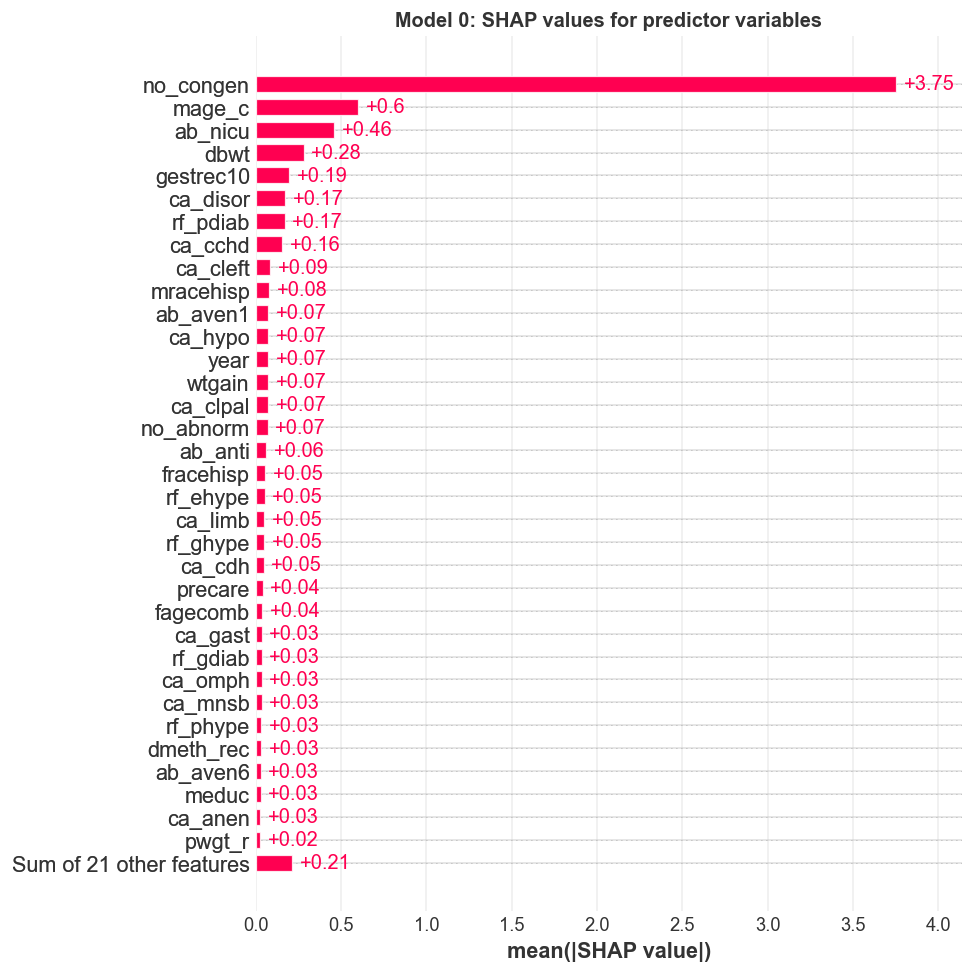

<Figure size 492x348 with 0 Axes>

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight"
        )
    plt.show()

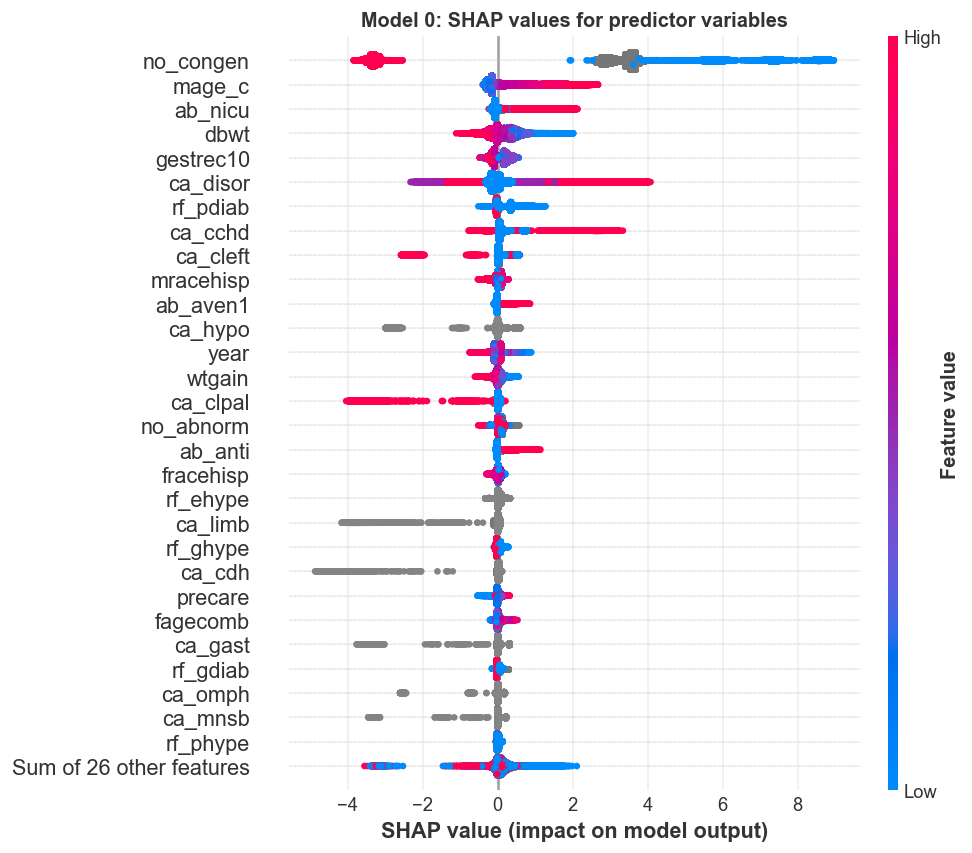

<Figure size 492x348 with 0 Axes>

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

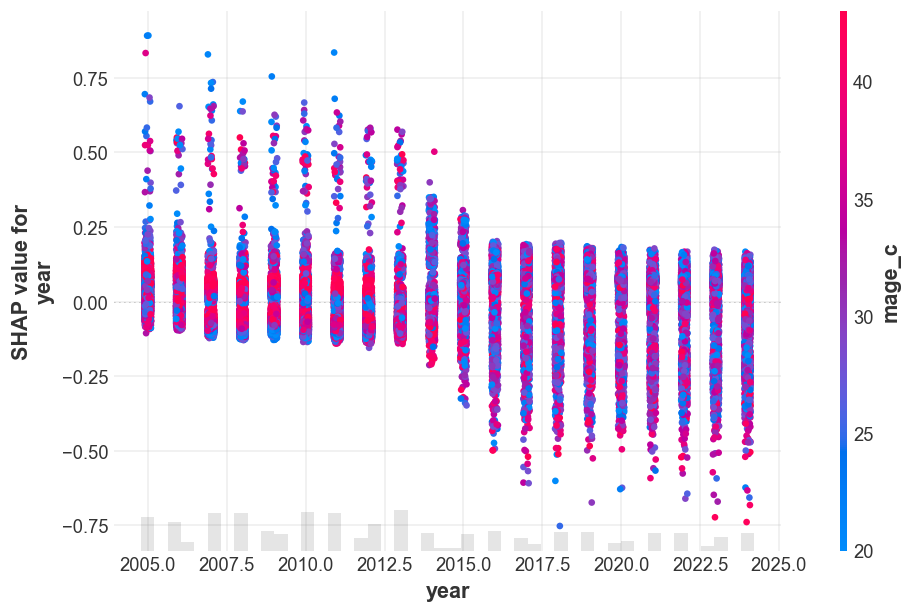

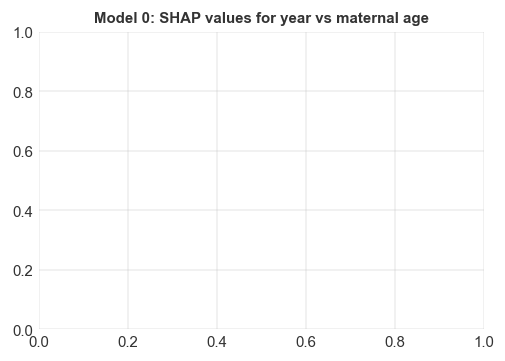

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [ ]:
features_to_remove_0 = [
    "fagecomb", # low SHAP value, correlated with mage_c
    "rf_gdiab", # low SHAP value, low permutation importance
    "rf_phype", # low SHAP value, low permutation importance    
    "ab_aven6", # low SHAP value, low permutation importance, correlated with ab_aven1
    "meduc", # low SHAP value, low permutation importance
    "ca_anen", # low SHAP value
    "pwgt_r",  # low SHAP value, correlated with bmi
    "dob_mm",  # low SHAP value, low permutation importance
    "bmi",  # low SHAP value
    "dob_wk",  # low SHAP value, low permutation importance
    "ld_indl",  # low SHAP value
    "me_pres",  # low SHAP value
    "sex",  # low SHAP value, low permutation importance
    "ab_seiz",  # low SHAP value, low permutation importance
    "feduc",  # low SHAP value, low permutation importance
    "ld_augm",  # low SHAP value, low permutation importance
    "pay_rec",  # low SHAP value, low permutation importance
    "rf_inftr",  # low SHAP value, low permutation importance
    "no_risks",  # low SHAP value, low permutation importance
    "rf_artec",  # low SHAP value, low permutation importance
    "ab_surf",  # low SHAP value, low permutation importance
    "wic",  # low SHAP value, low permutation importance
    "rf_fedrg",  # low SHAP value, low permutation importance
    "rf_ppterm",  # low SHAP value, low permutation importance
    "apgar10",  # low SHAP value, low permutation importance
    "dob_tt_pm",  # low SHAP value, low permutation importance
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['fracehisp', 'ab_aven6', 'pwgt_r', 'ld_indl', 'no_risks', 'feduc', 'pay_rec', 'rf_ghype', 'ab_surf', 'rf_inftr', 'ld_augm', 'rf_gdiab', 'sex', 'ab_seiz', 'rf_ppterm', 'wic', 'rf_artec', 'rf_fedrg', 'apgar10']
Features remaining: ['dob_mm', 'dob_wk', 'dob_tt_pm', 'bfacil3', 'precare', 'gestrec10', 'rf_pdiab', 'rf_phype', 'rf_ehype', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_nicu', 'ab_anti', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_gast', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_hypo', 'ca_disor', 'no_congen', 'meduc', 'mracehisp', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 1 (after removing 19 predictors): 36


In [26]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	train's average_precision: 0.499827	train's binary_logloss: 0.00287497	valid's average_precision: 0.48825	valid's binary_logloss: 0.00289981
[20]	train's average_precision: 0.508323	train's binary_logloss: 0.00267481	valid's average_precision: 0.497613	valid's binary_logloss: 0.00270634
[30]	train's average_precision: 0.519826	train's binary_logloss: 0.00254112	valid's average_precision: 0.509905	valid's binary_logloss: 0.00257674
[40]	train's average_precision: 0.52503	train's binary_logloss: 0.0024402	valid's average_precision: 0.515369	valid's binary_logloss: 0.00247922
[50]	train's aver

In [27]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [28]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.965634
1,Validation AP,0.551154
2,Validation log loss,0.001855
3,Precision at 10000,0.529200
4,Recall at 10000,0.532716
5,Precision (threshold=0.01),0.119984
6,Recall (threshold=0.01),0.616972


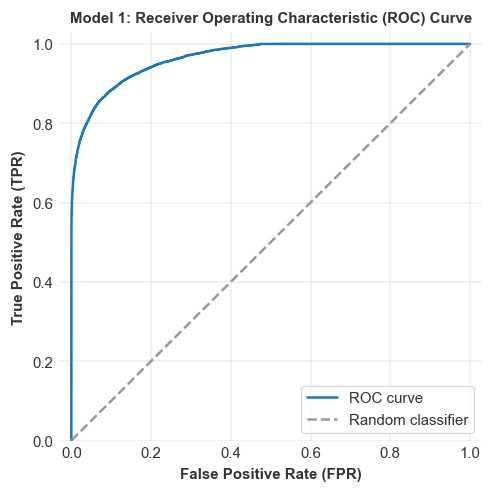

In [29]:
plot_utils.plot_roc_curve(p_valid_fpr, p_valid_tpr, model_idx, save=SAVE_PLOTS)

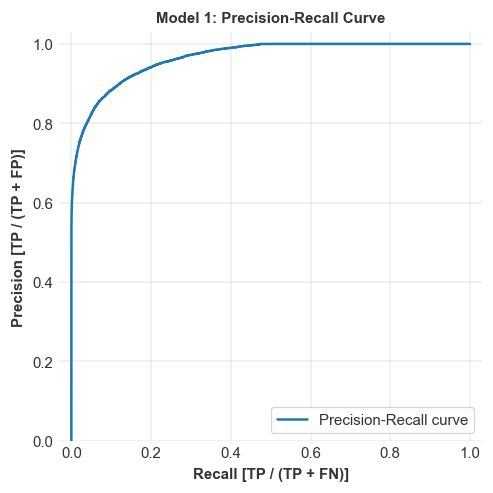

In [30]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr, p_valid_tpr, model_idx, save=SAVE_PLOTS
)

In [31]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
27,no_congen,3.418583e+06
26,ca_disor,3.295273e+05
34,mage_c,3.181566e+05
18,ca_cchd,2.846843e+05
25,ca_hypo,2.775545e+05
13,ab_nicu,2.719855e+05
23,ca_cleft,2.111660e+05
24,ca_clpal,1.605373e+05
31,dbwt,1.399878e+05
21,ca_gast,1.254958e+05


In [32]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [33]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=5,
    n_jobs=NUM_THREADS,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

KeyboardInterrupt: 

In [ ]:
plot_utils.plot_permutation_importances(result, X_eval, model_idx, save=SAVE_PLOTS)

In [ ]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

In [ ]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
)

In [ ]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

In [ ]:
shap_importance["feature"].tolist()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight"
        )
    plt.show()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [ ]:
features_to_remove_1 = [
    "precare",  # low importance, low SHAP value
    "bmi",  # low importance, low SHAP value
    "meduc",  # low importance, low SHAP value
    "fagecomb",  # low importance, low SHAP value, correlated with mage_c
    "rf_pdiab",  # low importance, low SHAP value
    "apgar5",  # low importance, low SHAP value
    "bfacil3",  # low importance, low SHAP value
    "dmeth_rec",  # low importance, low SHAP value
    "rf_phype",  # low importance, low SHAP value
    "me_pres",  # low importance, low SHAP value
    "mracehisp",  # partially correlated with year, possible bias
    "wtgain",  # low importance
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

In [ ]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [ ]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

In [ ]:
plot_utils.plot_roc_curve(p_valid_fpr, p_valid_tpr, model_idx, save=SAVE_PLOTS)

In [ ]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr, p_valid_tpr, model_idx, save=SAVE_PLOTS
)

In [ ]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

In [ ]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=5,
    n_jobs=NUM_THREADS,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/permutation_importance.csv",
    index=False,
)
perm_importance

In [ ]:
plot_utils.plot_permutation_importances(result, X_eval, model_idx, save=SAVE_PLOTS)

In [ ]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

In [ ]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
)

In [ ]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

In [ ]:
shap_importance["feature"].tolist()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight"
        )
    plt.show()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

Model 2


## Calibration


In [ ]:
p_cal_raw = gbm.predict(X_cal, num_iteration=gbm.best_iteration, raw_score=True)

In [ ]:
calibrator = LogisticRegression(solver="lbfgs", max_iter=1000)
calibrator.fit(p_cal_raw.reshape(-1, 1), y_cal)

In [ ]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration, raw_score=True)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

## Prediction


In [ ]:
p_valid_cal = predict_proba_calibrated(
    gbm, calibrator, X_valid, num_iteration=gbm.best_iteration
)
p_valid_raw = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

print("Raw logloss:", log_loss(y_valid, p_valid_raw, labels=[0, 1]))
print("Cal logloss:", log_loss(y_valid, p_valid_cal, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid_raw))
print("Cal brier:  ", brier_score_loss(y_valid, p_valid_cal))